<a href="https://colab.research.google.com/github/jonghechoi/jonghe/blob/master/Tensorflow2.0%20%2B%20Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 501kB 31.3MB/s 
     |████████████████████████████████| 4.3MB 48.2MB/s 


# 데이터 포맷

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import tensorflow as tf

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [2]:
def data_format():
    return 'channels_last' if tf.test.is_gpu_available() else 'channels_first'

print(data_format())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
channels_last


# 데이터 로드

In [6]:
import functools
from keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

def normalize(X_train, X_test):
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std 

    return X_train, X_test
  
def load_cifar10():
    (train_data, train_labels), (test_data, test_labels) = cifar10.load_data()
    # train_data = train_data / 255.0
    # test_data = test_data / 255.0
    train_data, test_data = normalize(train_data, test_data)

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    seed = 777
    np.random.seed(seed)
    np.random.shuffle(train_data)
    np.random.seed(seed)
    np.random.shuffle(train_labels)

    return train_data, train_labels, test_data, test_labels

# dataset 만들기
train_data, train_labels, test_data, test_labels = load_cifar10()


Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


# tf.data.Dataset

In [0]:
batch_size = 128
dataset_cifar10 = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset_cifar10 = dataset_cifar10.shuffle(buffer_size=200).batch(batch_size)

test_batch_size = 128
test_dataset_cifar10 = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset_cifar10 = test_dataset_cifar10.shuffle(buffer_size=1000).batch(test_batch_size)

# ResNet50 / IdentityBlock / ConvBlock

In [0]:
layers = tf.keras.layers

class _IdentityBlock(tf.keras.Model):
    """_IdentityBlock is the block that has no conv layer at shortcut.
    Args:
      kernel_size: the kernel size of middle conv layer at main path
      filters: list of integers, the filters of 3 conv layer at main path
      stage: integer, current stage label, used for generating layer names
      block: 'a','b'..., current block label, used for generating layer names
      data_format: data_format for the input ('channels_first' or 'channels_last').
    """
    
    def __init__(self,
                 kernel_size,
                 filters,
                 stage,
                 block,
                 data_format,
                 strides=(1,1)):
        # super가 뭐지?? 부모클래스(tf.keras.Model)를 초기화해주는 장치
        # 인자를 주지 않으면 자동으로 현재 클래스로 설정되고, 준다면 첫번째 인자는 클래스, 두번째는 인스턴스가 들어간다.
        # 첫번째 인자에 들어간 클래스의 부모클래스가 선택된다
        super(_IdentityBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters
        
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        # 'channels_first'라면 channels의 수가 (0,1,2,3) 중에 1번 인자에 들어가게 되므로 축을 1로 삼는다.
        bn_axis = 1 if data_format == 'channels_first' else 3
        
        self.conv2a = layers.Conv2D(
                filters1, 
                (1, 1),
                strides=strides,
                name=conv_name_base + '2a',
                data_format=data_format)
        self.bn2a = layers.BatchNormalization(axis = bn_axis, name=bn_name_base + '2a')
       
        self.conv2b = layers.Conv2D(
                filters2,
                kernel_size,
                kernel_initializer='he_normal',
                strides=strides,
                padding='same',
                data_format=data_format,
                name=conv_name_base + '2b')
        self.bn2b = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')
        
        self.conv2c = layers.Conv2D(
                filters3,
                (1, 1),
                strides=strides,
                name=conv_name_base + '2c',
                data_format=data_format)
        self.bn2c = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')
        
    ''' full pre-activation 적용 '''
    def call(self, input_tensor, training=True):
        x = self.bn2a(input_tensor, training = training)
        x = tf.nn.relu(x)
        x = self.conv2a(x)

        x = self.bn2b(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = self.bn2c(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2c(x)
        
        x += input_tensor
        return x



class _ConvBlock(tf.keras.Model):
  
    """_ConvBlock은 short connection에서 feature의 개수를 맞춰주기 위해 1x1컨볼루션 연산을 수행
    Args:
        kernel_size: the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        data_format: data_format for the input ('channels_first' or
        'channels_last').
        strides: strides for the convolution. Note that from stage 3, the first
        conv layer at main path is with strides=(2,2), and the shortcut should
        have strides=(2,2) as well.
        
        기존 _ConvBlock에서 몇가지를 수정한다.
        1. conv_shortcut의 필터의 수를 filter1 에서 filter3로 수정한다.
        2. padding='same'으로 하여 이미지 크기가 축소되지 않게 한다.
    """
    
    def __init__(self,
                 kernel_size,
                 filters,
                 stage,
                 block,
                 data_format,
                 strides=(1,1)):
        super(_ConvBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters
        
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        bn_axis = 1 if data_format == 'channels_first' else 3
    
        self.conv2a = layers.Conv2D(
                filters1,
                (1,1),
                strides=strides,
                name = conv_name_base + '2a',
                data_format = data_format)
        self.bn2a = layers.BatchNormalization(axis = bn_axis, name = bn_name_base + '2a')

        self.conv2b = layers.Conv2D(
                filters2,
                kernel_size,
                kernel_initializer='he_normal',
                strides=strides,
                padding='same',
                name = conv_name_base + '2b',
                data_format = data_format)
        self.bn2b = layers.BatchNormalization(axis = bn_axis, name = bn_name_base + '2b')

        self.conv2c = layers.Conv2D(
                filters3,
                (1,1),
                strides=strides,
                name = conv_name_base + '2c',
                data_format = data_format)
        self.bn2c = layers.BatchNormalization(axis = bn_axis, name = bn_name_base + '2c')

        # conv_shortcut의 필터의 수를 building_block의 마지막 필터 개수인 filter3로 해야하는 것 아닌가 ?
        # 일단은 filter1 -> filter3 로 변경해봄.
        self.conv_shortcut = layers.Conv2D(
                filters3,
                (1,1),
                strides=strides,
                name = conv_name_base + '1',
                data_format = data_format)

    def call(self, input_tensor, training=True):
        x = self.bn2a(input_tensor, training = training)
        x = tf.nn.relu(x)
        x = self.conv2a(x)

        x = self.bn2b(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = self.bn2c(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2c(x)
        
        shortcut = self.conv_shortcut(input_tensor)     
        
        x += shortcut
        return x





class ResNet50(tf.keras.Model):
    """Instantiates the ResNet50 architecture.
    Args:
      data_format: format for the image. Either 'channels_first' or 'channels_last'.
      'channels_first' is typically faster on GPUs while 'channels_last' is typically faster on CPUs.
      See "https://www.tensorflow.org/performance/performance_guide#data_formats"
      
      name: Prefix applied to names of variables created in the model.
      
      trainable: Is the model trainable? If true, performs backward and optimization after call() method.
      
      include_top: whether to include the fully-connected layer at the top of the network.
      
      pooling: Optional pooling mode for feature extraction when `include_top` is `False`.
        - `None` means that the output of the model will be the 4D tensor output of the last convolutional layer.
        - `avg` means that global average pooling will be applied to the output of the last convolutional layer,
           and thus the output of the model will be a 2D tensor.
        - `max` means that global max pooling will be applied.
        
      classes: optional number of classes to classify images into, only to be specified if `include_top` is True.
    
    Raises:
        ValueError: in case of invalid argument for data_format.
    """
    
    
    def __init__(self,
                 data_format,
                 name = '',
                 trainable = True,
                 include_top = True,
                 pooling = None,
                 classes = 10):
        super(ResNet50, self).__init__(name = name)
        
        valid_channel_values = ('channels_first', 'channels_last')
        if data_format not in valid_channel_values:
            raise ValueError('Unknown data_format: %s. Valid values: %s' % (data_format, valid_channel_values))
        self.include_top = include_top
        
        def conv_block(filters, stage, block, strides=(1,1)):
            return _ConvBlock((3,3), filters, stage = stage, block = block, data_format = data_format, strides = strides)
        
        def id_block(filters, stage, block):
            return _IdentityBlock((3,3), filters, stage = stage, block = block, data_format = data_format)
        
        self.conv1 = layers.Conv2D(
                64,
                (3,3),
                strides = (1,1),
                padding = 'same',
                data_format = data_format,
                name = 'conv1')
        
        bn_axis = 1 if data_format == 'channels_first' else 3
        self.bn_conv1 = layers.BatchNormalization(axis = bn_axis, name = 'bn_conv1')
        self.max_pool = layers.MaxPooling2D(
                (3,3), strides = (2,2), data_format = data_format)
        
        self.l2a = conv_block([64, 64, 256], stage = 2, block = 'a', strides=(1, 1))
        self.l2b = id_block([64,64,256], stage = 2, block = 'b')
        self.l2c = id_block([64,64,256], stage = 2, block = 'c')
        
        self.l3a = conv_block([128,128,512], stage = 3, block = 'a')
        self.l3b = id_block([128,128,512], stage = 3, block = 'b')
        self.l3c = id_block([128,128,512], stage = 3, block = 'c')
        self.l3d = id_block([128,128,512], stage = 3, block = 'd')
        
        self.l4a = conv_block([256,256,1024], stage = 4, block = 'a')
        self.l4b = id_block([256,256,1024], stage = 4, block = 'b')
        self.l4c = id_block([256,256,1024], stage = 4, block = 'c')
        self.l4d = id_block([256,256,1024], stage = 4, block = 'd')
        self.l4e = id_block([256,256,1024], stage = 4, block = 'e')
        self.l4f = id_block([256,256,1024], stage = 4, block = 'f')
        
        self.l5a = conv_block([512,512,2048], stage = 5, block = 'a')
        self.l5b = id_block([512,512,2048], stage = 5, block = 'b')
        self.l5c = id_block([512,512,2048], stage = 5, block = 'c')
    
        self.avg_pool = layers.AveragePooling2D((7,7), strides = (2,2), data_format = data_format)
        
        if self.include_top:
            self.flatten = layers.Flatten()
            self.fc100 = layers.Dense(classes, activation='softmax', name = 'fc100')
        else:
            reduction_indices = [1, 2] if data_format == 'channels_last' else [2, 3]
            reduction_indices = tf.constant(reduction_indices)
            if pooling == 'avg':
                self.global_pooling = functools.partial(
                        tf.reduce_mean,
                        reduction_indices = reduction_indices,
                        keep_dims = False)
            elif pooling == 'max':
                self.global_pooling = functools.partial(
                        tf.reduce_max, reduction_indices = reduction_indices, keep_dims = False)
            else:
                self.global_pooling = None
    
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        
        x = self.bn_conv1(x, training=training)
        x = tf.nn.relu(x)
        x = self.max_pool(x)

        
        x = self.l2a(x, training=training)
        x = self.l2b(x, training=training)
        x = self.l2c(x, training=training)


        x = self.l3a(x, training=training)
        x = self.l3b(x, training=training)
        x = self.l3c(x, training=training)
        x = self.l3d(x, training=training)

        
        x = self.l4a(x, training=training)
        x = self.l4b(x, training=training)
        x = self.l4c(x, training=training)
        x = self.l4d(x, training=training)
        x = self.l4e(x, training=training)
        x = self.l4f(x, training=training)


        x = self.l5a(x, training=training)
        x = self.l5b(x, training=training)
        x = self.l5c(x, training=training)
        
        x = self.avg_pool(x)
        
        if self.include_top:
            x = self.flatten(x)
            return self.fc100(x)
        elif self.global_pooling:
          return self.global_pooling(x)
        else:
          return x

# Gradient Tape (저수준 학습)

In [0]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# 로스, 정확도에 대한 metric의 인스턴스 생성
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [0]:
'''train_accuracy 커스터마이징'''

@tf.function
def compute_accuracy(y_pred, y):
  correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  return accuracy

In [0]:
myResNet50 = ResNet50(data_format())
    

# tape에 학습과정을 기록
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = myResNet50(x, training=True)     
        loss_value = loss(y, predictions)
    
    # 모델에서 기록된 순전파의 내용들을 tape에서 거꾸로 되감기하면서 loss값에 대해서 가중치의 미분값을 계산
    gradients = tape.gradient(loss_value, myResNet50.trainable_variables)
    # 계산된 미분값을 가중치에 적용
    optimizer.apply_gradients(zip(gradients, myResNet50.trainable_variables))
        
    # 현재까지 수행된 전체에 대한 모델의 정확도를 갱신, but 커스터마이징한 것으로 처리함
    train_loss(loss_value)
    #train_accuracy(y, predictions)

    return predictions
    

    
    
for epoch in range(30):
    for step, (x, y) in enumerate(dataset_cifar10, 1):
        predictions = train_step(x, y)  
        
        template = 'epoch: {}, step: {}, train_loss: {}, train_accuracy: {}'
        print( template.format(epoch,
                               step,
                               train_loss.result(),
                               compute_accuracy(predictions, y)*100))

In [0]:
for step, (x, y) in enumerate(dataset_cifar10, 1):
    with tf.GradientTape() as tape:
        predictions = myResNet50(x, training=True)     
        loss_value = loss(y, predictions)
    
    # 모델에서 기록된 순전파의 내용들을 tape에서 거꾸로 되감기하면서 loss값에 대해서 가중치의 미분값을 계산
    gradients = tape.gradient(loss_value, myResNet50.trainable_variables)
    # 계산된 미분값을 가중치에 적용
    optimizer.apply_gradients(zip(gradients, myResNet50.trainable_variables))

# ResNet50.fit (고수준 학습)

In [0]:
myResNet50 = ResNet50(data_format())

myResNet50.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                   loss= tf.keras.losses.CategoricalCrossentropy(),
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])


myResNet50.fit(train_data, train_labels, batch_size=128, epochs=5)

이렇게 저수준/고수준 학습까지 모두 만들고 실행되는 것을 확인했다. 결과 값은 바로 밑의 "cifar10을 100에폭 학습시켰을 때의 정확도와 시간"에서 확인할 수 있다.

다음으로는 data flow를 보기 위해 모델의 아키텍처를 시각화하려 했다.
하지만 Keras document를 확인해보니 subclass network 버전의 모델은 시각화가 지원되지 않는 것 같다. 시각화는 functional network 버전에서 가능한데 아래의 "모델 아키텍처" 이후 부분에서 구현했다.

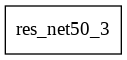

In [0]:
tf.keras.utils.plot_model(myResNet50, show_shapes=True)

# cifar10을 100에폭 학습시켰을 때의 정확도와 시간


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 232s 5ms/sample - loss: 2.5015 - categorical_accuracy: 0.5124 - val_loss: 1.6122 - val_categorical_accuracy: 0.4597
Epoch 2/30
50000/50000 [==============================] - 227s 5ms/sample - loss: 0.9733 - categorical_accuracy: 0.6613 - val_loss: 0.9912 - val_categorical_accuracy: 0.6539
Epoch 3/30
50000/50000 [==============================] - 227s 5ms/sample - loss: 0.8302 - categorical_accuracy: 0.7113 - val_loss: 1.1054 - val_categorical_accuracy: 0.6634
Epoch 4/30
50000/50000 [==============================] - 227s 5ms/sample - loss: 0.7445 - categorical_accuracy: 0.7434 - val_loss: 0.9153 - val_categorical_accuracy: 0.7044
Epoch 5/30
50000/50000 [==============================] - 227s 5ms/sample - loss: 0.6775 - categorical_accuracy: 0.7691 - val_loss: 0.7791 - val_categorical_accuracy: 0.7400
Epoch 6/30
50000/50000 [==============================] - 227s 5ms/sample - loss

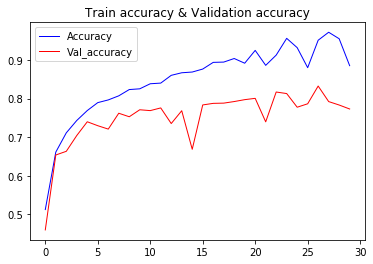

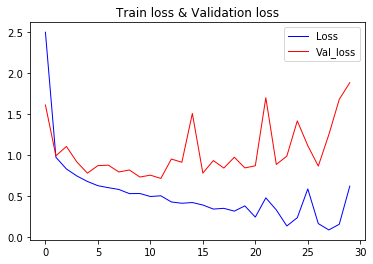

In [0]:
import time

myResNet50 = ResNet50(data_format())

myResNet50.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss= tf.keras.losses.CategoricalCrossentropy(),
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])


callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)

time_start = time.time()

history = myResNet50.fit(train_data, train_labels, batch_size=128, epochs=30, callbacks=[callback], 
                         validation_data=(test_data, test_labels))

time_end = time.time() - time_start

print( time.strftime("%H 시간: %M 분: %S 초", time.gmtime(time_end)) )



myResNet50.save_weights('/content/drive/My Drive/test_colab/my_resnet50_cifar10.h5')

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy_dict = {}
for i, j in zip(['acc', 'val_acc', 'loss', 'val_loss'], [acc, val_acc, loss, val_loss]):
    accuracy_dict[i] = j

f = open('/content/drive/My Drive/test_colab/my_resnet50_cifar10_info.pickle', 'wb')
pickle.dump(accuracy_dict, f)
f.close()



# 결과값(그래프)

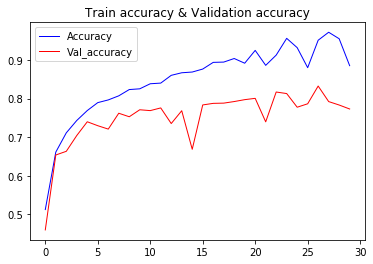

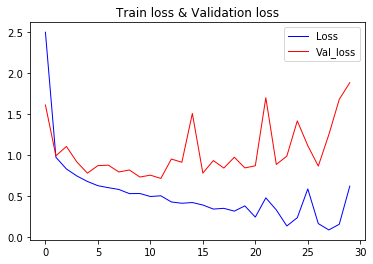

In [0]:
import pickle
import matplotlib.pyplot as plt

# pickle 파일로부터 결과값 불러오기
ff = open('/content/drive/My Drive/test_colab/my_resnet50_cifar10_info.pickle', 'rb')
accuracy = pickle.load(ff)
ff.close()

accuracy_redict = {}
for idx, i in accuracy.items():
    accuracy_redict[idx] = i

epochs = range(len(accuracy_redict['acc']))

plt.plot(epochs, accuracy_redict['acc'], 'b', label='Accuracy', linewidth=1)
plt.plot(epochs, accuracy_redict['val_acc'], 'r', label='Val_accuracy', linewidth=1)
plt.title('Train accuracy & Validation accuracy')
plt.legend()

plt.figure()

# validation 데이터의 loss가 낮아지다가 높아지기시작하면 이는 과적합의 신호
plt.plot(epochs, accuracy_redict['loss'], 'b', label='Loss', linewidth=1)
plt.plot(epochs, accuracy_redict['val_loss'], 'r', label='Val_loss', linewidth=1)
plt.title('Train loss & Validation loss')
plt.legend()

plt.show()

# 구글 드라이브 연동 방법


In [0]:
''' 구글 드라이브 연동
colab에 구글 드라이브를 연결하면 구글 드라이브에서 데이터 파일을 열거나 저장할 수도 있다.
colab을 실행 중인 상태에서 다음 코드를 실행하면 구글 드라이브를 /content/drive/라는 이름의
드라이브로 colab에 마운트(mount)시킨다.

출처 : 데이터 사이언스 스쿨('https://datascienceschool.net/view-notebook/f9d9fddb7cc7494a9e4be99f0e137be0/')
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 연결이 되면 다음과 같이 배시 셸 명령어로 폴더를 확인할 수 있다.
!ls '/content/drive/'

'My Drive'


In [0]:
# 이 드라이브에는 구글 드라이브가 My drive라는 이름의 폴더로 마운트되어 있다.
# 시험삼아 이 폴더 아래에 test_colab 이라는 폴더를 만들자.
!mkdir -p '/content/drive/My Drive/test_colab'
!ls -Fcal '/content/drive/My Drive/test_colab'

total 0


In [0]:
# 데이터의 저장은 아래와 같이 이루어진다.

import numpy as np
import pandas as pd

df = pd.DataFrame(np.random.rand(10, 5))
df.to_csv('/content/drive/My Drive/test_colab/df.csv')

# Keras 내장 ResNet50 

Keras의 내장 Resnet50의 모델 아키텍처는 잘 나온다.

In [16]:
resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = True)

102973440/102967424 [==============================] - 1s 0us/step


In [0]:
resnet50.summary()

In [0]:
tf.keras.utils.plot_model(resnet50, show_shapes=True)

# myResNet50 모델 아키텍처

하지만 subclass network 버전으로 만든 나의 모델은 시각화가 잘 되지 않는다.

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(myResNet50, show_shapes=True).create(prog='dot', format='svg'))

#keras.utils.plot_model(myResNet50, show_shapes=True)

각 layer 층의 input/output shape 또한 확인이 불가능했다.

In [0]:
myResNet50.summary()

Model: "res_net50_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               multiple                  1792      
_________________________________________________________________
bn_conv1 (BatchNormalization multiple                  256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
private__conv_block_12 (_Con multiple                  75136     
_________________________________________________________________
private__identity_block_36 ( multiple                  71552     
_________________________________________________________________
private__identity_block_37 ( multiple                  71552     
_________________________________________________________________
private__conv_block_13 (_Con multiple                  

# Graph Network 버전

**모델 아키텍처 시각화에 불편함이 있는 subclass network가 아닌 functional network 버전의 모델 또한 만들었습니다.**

In [0]:
from tensorflow import keras

layers = tf.keras.layers
classes = 10

def data_format():
    return 'channels_last' if tf.test.is_gpu_available() else 'channels_first'

bn_axis = 1 if data_format == 'channels_first' else 3

In [0]:
def convblock(input_tensor, filters, stage, block):
    filters1, filters2, filters3 = filters
    
    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_1' + block)(input_tensor)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_1' + block)
    x = layers.Conv2D(filters1, 1, padding='same', name='stage' + str(stage) + '_conv1' + block, data_format = data_format())(x)

    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_2' + block)(x)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_2' + block)
    x = layers.Conv2D(filters2, 3, padding='same', name='stage' + str(stage) + '_conv2' + block, data_format = data_format())(x)

    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_3' + block) (x)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_3' + block)
    output_tensor = layers.Conv2D(filters3, 1, padding='same', name='stage' + str(stage) + '_conv3' + block, data_format = data_format())(x)

    input_conv = layers.Conv2D(filters3, 1, name='short_connection_' + str(stage))(input_tensor)

    output_tensor = layers.Add()([output_tensor, input_conv])

    return output_tensor


def identityblock(input_tensor, filters, stage, block):
    filters1, filters2, filters3 = filters
    
    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_1' + block)(input_tensor)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_1' + block)
    x = layers.Conv2D(filters1, 1, padding='same', name='stage' + str(stage) + '_conv1' + block, data_format = data_format())(x)

    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_2' + block)(x)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_2' + block)
    x = layers.Conv2D(filters2, 3, padding='same', name='stage' + str(stage) + '_conv2' + block, data_format = data_format())(x)

    x = layers.BatchNormalization(axis=bn_axis, name='stage' + str(stage) + '_bn_3' + block) (x)
    x = tf.nn.relu(x, name='stage' + str(stage) + '_relu_3' + block)
    output_tensor = layers.Conv2D(filters3, 1, padding='same', name='stage' + str(stage) + '_conv3' + block, data_format = data_format())(x)

    output_tensor = layers.Add()([output_tensor, input_tensor])

    return output_tensor

In [22]:
input_tensor = keras.Input(shape=(32, 32, 3), name='input')

x = layers.Conv2D(64, 3, strides=(1,1), padding='same', data_format=data_format(), name='conv1')(input_tensor)
print('a:', x.shape)
x = layers.BatchNormalization(axis = bn_axis, name = 'bn_conv1')(x)
x = layers.MaxPooling2D((3,3), strides = (2,2), data_format = data_format())(x)
print('b:', x.shape)

x = convblock(x, [64, 64, 256], stage=2, block='a')
x = identityblock(x, [64, 64, 256], stage=2, block='b')
x = identityblock(x, [64, 64, 256], stage=2, block='c')
print('c:', x.shape)
x = convblock(x, [128,128,512], stage=3, block='a')
x = identityblock(x, [128,128,512], stage=3, block='b')
x = identityblock(x, [128,128,512], stage=3, block='c')
x = identityblock(x, [128,128,512], stage=3, block='d')
print('d:', x.shape)
x = convblock(x, [256,256,1024], stage=4, block='a')
x = identityblock(x, [256,256,1024], stage=4, block='b')
x = identityblock(x, [256,256,1024], stage=4, block='c')
x = identityblock(x, [256,256,1024], stage=4, block='d')
x = identityblock(x, [256,256,1024], stage=4, block='e')
x = identityblock(x, [256,256,1024], stage=4, block='f')
print('e:', x.shape)
x = convblock(x, [512,512,2048], stage=5, block='a')
x = identityblock(x, [512,512,2048], stage=5, block='b')
x = identityblock(x, [512,512,2048], stage=5, block='c')

x = layers.AveragePooling2D((7,7), strides = (2,2), data_format = data_format())(x)
x = layers.Flatten()(x)
output_tensor = layers.Dense(classes, activation='softmax', name = 'fc100')(x)

my_resnet50 = keras.Model(input_tensor, output_tensor, name='my_resnet')


a: (None, 32, 32, 64)
b: (None, 15, 15, 64)
c: (None, 15, 15, 256)
d: (None, 15, 15, 512)
e: (None, 15, 15, 1024)


아래 보이듯이 functional network 모델을 이용하면 각각의 building block들이 어떤 흐름으로 이어지는지가 시각적으로 잘 표현됩니다.

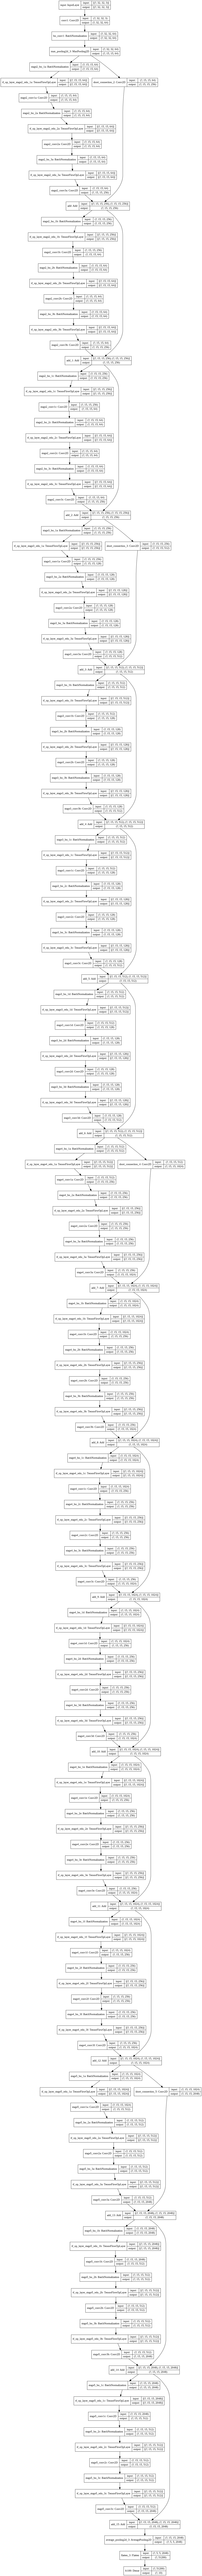

In [23]:
tf.keras.utils.plot_model(my_resnet50, show_shapes=True)

model.summary()로 input/output shape 또한 간단히 표현할 수 있습니다.

In [24]:
my_resnet50.summary()

Model: "my_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 15, 15, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________

# Graph Network 버전 (고수준 학습)

In [0]:
my_resnet50.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                   loss= tf.keras.losses.CategoricalCrossentropy(),
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])


my_resnet50.fit(train_data, train_labels, batch_size=128, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 230s 5ms/sample - loss: 2.8597 - categorical_accuracy: 0.4964
Epoch 2/5
50000/50000 [==============================] - 215s 4ms/sample - loss: 1.0158 - categorical_accuracy: 0.6498
Epoch 3/5
50000/50000 [==============================] - 215s 4ms/sample - loss: 0.8396 - categorical_accuracy: 0.7087
Epoch 4/5
50000/50000 [==============================] - 215s 4ms/sample - loss: 0.7683 - categorical_accuracy: 0.7384
Epoch 5/5
50000/50000 [==============================] - 215s 4ms/sample - loss: 0.6829 - categorical_accuracy: 0.7669


# Graph Network 버전 (저수준 학습)

In [0]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# 로스, 정확도에 대한 metric의 인스턴스 생성
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

'''train_accuracy 커스터마이징'''
@tf.function
def compute_accuracy(y_pred, y):
  correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

   
# tape에 학습과정을 기록
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        
        predictions = my_resnet50(x, training=True)
        loss_value = loss(y, predictions)
    
    # 모델에서 기록된 순전파의 내용들을 tape에서 거꾸로 되감기하면서 loss값에 대해서 가중치의 미분값을 계산
    gradients = tape.gradient(loss_value, my_resnet50.trainable_variables)
    # 계산된 미분값을 가중치에 적용
    optimizer.apply_gradients(zip(gradients, my_resnet50.trainable_variables))
        
    # 현재까지 수행된 전체에 대한 모델의 정확도를 갱신, but 커스터마이징한 것으로 처리함
    train_loss(loss_value)
    #train_accuracy(y, predictions)

    return predictions
    
@tf.function
def test_step(x):
    prediction = my_resnet50(x)
    return prediction

In [0]:
import time
import pickle

total_step = 0
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

total_time = time.time()
for epoch in range(1, 30):
    time_start = time.time()
    for step, (x, y) in enumerate(dataset_cifar10, 1):
        predictions = train_step(x, y)  
        train_accuracy = compute_accuracy(predictions, y)
        template = 'epoch: {}, step: {}, train_loss: {}, train_accuracy: {}'
        print( template.format(epoch,
                            step,
                            train_loss.result(),
                            train_accuracy*100))
        
        total_step += 1
        train_loss_list.append(train_loss.result()) 
        
    time_end = time.time() - time_start
    print( f'한 에폭에 소요된 시간 - {time.strftime("%H 시간: %M 분: %S 초", time.gmtime(time_end))}' )

    train_accuracy_list.append(train_accuracy)

    for test_data, test_labels in test_dataset_cifar10.take(1):
    
        test_predictions = test_step(test_data)

        test_res = compute_accuracy(test_predictions, test_labels)
        test_accuracy_list.append(test_res)
        print('test_accuracy : %s'%(round(test_res.numpy()*100, 3)))

total_end_time = time.time() - total_time
print(f'총 소요 시간 - {time.strftime("%H 시간: %M 분: %S 초", time.gmtime(total_end_time))}')

my_resnet50.save_weights('/content/drive/My Drive/test_colab/my_resnet50_cifar10_Graph_Network.h5')

accuracy_dict = {}
for i, j in zip(['train_accuracy', 'test_accuracy', 'train_loss'], [train_accuracy_list, test_accuracy_list, train_accuracy_list]):
    accuracy_dict[i] = j

f = open('/content/drive/My Drive/test_colab/my_resnet50_cifar10_info_Graph_Network.pickle', 'wb')
pickle.dump(accuracy_dict, f)
f.close()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch: 17, step: 111, train_loss: 0.2902059257030487, train_accuracy: 95.3125
epoch: 17, step: 112, train_loss: 0.2901701033115387, train_accuracy: 98.4375
epoch: 17, step: 113, train_loss: 0.29014742374420166, train_accuracy: 95.3125
epoch: 17, step: 114, train_loss: 0.2901226580142975, train_accuracy: 96.09375
epoch: 17, step: 115, train_loss: 0.2900931239128113, train_accuracy: 96.09375
epoch: 17, step: 116, train_loss: 0.29006561636924744, train_accuracy: 97.65625
epoch: 17, step: 117, train_loss: 0.2900383174419403, train_accuracy: 96.09375
epoch: 17, step: 118, train_loss: 0.29001009464263916, train_accuracy: 95.3125
epoch: 17, step: 119, train_loss: 0.28997910022735596, train_accuracy: 96.09375
epoch: 17, step: 120, train_loss: 0.2899782061576843, train_accuracy: 92.96875
epoch: 17, step: 121, train_loss: 0.289949506521225, train_accuracy: 93.75
epoch: 17, step: 122, train_loss: 0.2899116277694702, train_accuracy: 97.65625
epoch: 17, step: 123

NameError: ignored

In [0]:
total_end_time = time.time() - total_time
print(f'총 소요 시간 - {time.strftime("%H 시간: %M 분: %S 초", time.gmtime(total_end_time))}')

my_resnet50.save_weights('/content/drive/My Drive/test_colab/my_resnet50_cifar10_Graph_Network.h5')

accuracy_dict = {}
for i, j in zip(['train_accuracy', 'test_accuracy', 'train_loss'], [train_accuracy_list, test_accuracy_list, train_loss_list]):
    accuracy_dict[i] = j

f = open('/content/drive/My Drive/test_colab/my_resnet50_cifar10_info_Graph_Network.pickle', 'wb')
pickle.dump(accuracy_dict, f)
f.close()

총 소요 시간 - 01 시간: 50 분: 08 초


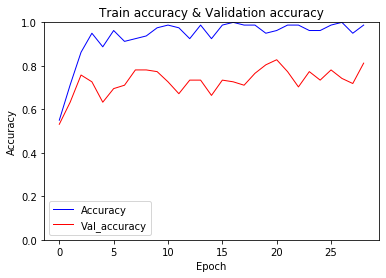

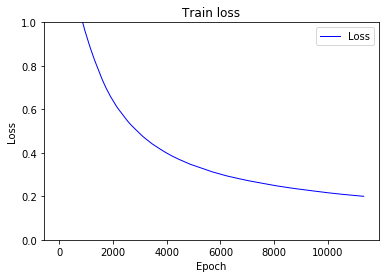

In [0]:
import pickle
import matplotlib.pyplot as plt

# pickle 파일로부터 결과값 불러오기
ff = open('/content/drive/My Drive/test_colab/my_resnet50_cifar10_info_Graph_Network.pickle', 'rb')
accuracy = pickle.load(ff)
ff.close()

accuracy_redict = {}
for idx, i in accuracy.items():
    accuracy_redict[idx] = i

epochs = range(len(accuracy_redict['train_accuracy']))
epochs2 = range(len(accuracy_redict['train_loss']))

plt.plot(epochs, accuracy_redict['train_accuracy'], 'b', label='Accuracy', linewidth=1)
plt.plot(epochs, accuracy_redict['test_accuracy'], 'r', label='Val_accuracy', linewidth=1)
plt.ylim(0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train accuracy & Validation accuracy')
plt.legend()

plt.figure()

# validation 데이터의 loss가 낮아지다가 높아지기시작하면 이는 과적합의 신호
plt.plot(epochs2, accuracy_redict['train_loss'], 'b', label='Loss', linewidth=1)
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
